# Parameter Selection for NMF

Now we look at the more advanced task of parameter selection for NMF topic modelling - namely, selecting a useful value for the number of topics *k*.

First, let's load the TF-IDF normalised document-term matrix and list of terms that we stored earlier using *Joblib*:

In [645]:
from sklearn.externals import joblib
(A,terms,snippets) = joblib.load( "articles-tfidf.pkl" )
print( "Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )

Loaded 2009 X 318 document-term matrix


### Create the Topic Models

A common approach for parameter selection is to Measure and compare the topic coherence of models generated for different values of *k*.

We need to start by pre-specifying an initial range of "sensible" values:

In [627]:
kmin, kmax = 6, 50

Apply NMF for each of these values:

In [629]:
from sklearn import decomposition
topic_models = []
# try each value of k
for k in range(kmin,kmax+1):
    print("Applying NMF for k=%d ..." % k )
    # run NMF
    model = decomposition.NMF( init="nndsvd", n_components=k ) 
    W = model.fit_transform( A )
    H = model.components_    
    # store for later
    topic_models.append( (k,W,H) )

Applying NMF for k=6 ...
Applying NMF for k=7 ...
Applying NMF for k=8 ...
Applying NMF for k=9 ...
Applying NMF for k=10 ...
Applying NMF for k=11 ...
Applying NMF for k=12 ...
Applying NMF for k=13 ...
Applying NMF for k=14 ...
Applying NMF for k=15 ...
Applying NMF for k=16 ...
Applying NMF for k=17 ...
Applying NMF for k=18 ...
Applying NMF for k=19 ...
Applying NMF for k=20 ...
Applying NMF for k=21 ...
Applying NMF for k=22 ...
Applying NMF for k=23 ...
Applying NMF for k=24 ...
Applying NMF for k=25 ...
Applying NMF for k=26 ...
Applying NMF for k=27 ...
Applying NMF for k=28 ...
Applying NMF for k=29 ...
Applying NMF for k=30 ...
Applying NMF for k=31 ...
Applying NMF for k=32 ...
Applying NMF for k=33 ...
Applying NMF for k=34 ...
Applying NMF for k=35 ...
Applying NMF for k=36 ...
Applying NMF for k=37 ...
Applying NMF for k=38 ...
Applying NMF for k=39 ...
Applying NMF for k=40 ...
Applying NMF for k=41 ...
Applying NMF for k=42 ...
Applying NMF for k=43 ...
Applying NMF for

### Build a Word Embedding

To select the number of topics, here we will use a *topic coherence* measure called TC-W2V. This measure relies on the use of a *word embedding* model constructed from our corpus. So in this step we will use the *Gensim* implementation of Word2Vec to build a Word2Vec model based on our collection of news articles.

**Note:** If you want to skip this step, a pre-built Word2Vec model for the sample dataset [is also provided here for download](http://erdos.ucd.ie/files/pydata/w2v-model.bin) (71MB).

We read the documents from the input file again:

In [630]:
import os.path
import csv
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import gensim
import os
import sys
from scipy import sparse
import pickle
import json
from gensim.parsing.preprocessing import STOPWORDS

raw_documents = []

file_path = 'Train_all_types_hashes.csv'
csv.register_dialect("hashes", delimiter="#")

with open(file_path, "r", encoding="utf8") as fin:
    csv_reader = csv.reader(fin, delimiter="#")

    for line in csv_reader:
        # text = line[0].strip()
        text = gensim.utils.to_unicode(line[0], 'latin1').strip()
        msg = list(gensim.utils.tokenize(text, lower=True))
        msg = ' '.join(msg)
        raw_documents.append( msg )


print("Read %d raw text documents" % len(raw_documents))

Read 2009 raw text documents


Read the custom stopword list:

In [631]:
custom_stop_words = []
with open( "stopwords.txt", "r" ) as fin:
    for line in fin.readlines():
        custom_stop_words.append( line.strip().lower() )
# note that we need to make it hashable
print("Stopword list has %d entries" % len(custom_stop_words) )

Stopword list has 350 entries


First, we need to define a class that will generate documents in a form that can be consumed by Gensim's Word2Vec implementation:

In [632]:
import re
class TokenGenerator:
    def __init__( self, documents, stopwords ):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__( self ):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 2:
                    tokens.append( tok )
            yield tokens

Now build a Skipgram Word2Vec model from all documents in the input file using *Gensim*:

In [633]:
import gensim
docgen = TokenGenerator( raw_documents, custom_stop_words )
# print(len(docgen.documents))
# the model has 219 dimensions, the minimum document-term frequency is 20
w2v_model = gensim.models.Word2Vec(docgen, sg=1,size=350, min_count=15) # 

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...


In [634]:
print( "Model has %d terms" % len(w2v_model.wv.vocab) )

Model has 410 terms


Save for later use, so that we do not need to rebuild it:

In [635]:
w2v_model.save("w2v-model.bin")

In [636]:
# To re-load this model, run
#w2v_model = gensim.models.Word2Vec.load("w2v-model.bin")

### Selecting the Number of Topics

Once we have our Word2vec model, we can use it as part of our *topic coherence* approach to evaluate the different NMF topic models that we created previously. To do this, we will implement a simple version of the TC-W2V coherence measure.

We use the Word2vec model to calculate coherence scores for each of these models. We will define this coherence score as follows:

In [637]:
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            if pair[0] not in w2v_model.wv.vocab or pair[1] not in  w2v_model.wv.vocab:
                continue
            pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

We also define a function to get the topic descriptor (i.e. list of top terms) for each topic:

In [638]:
import numpy as np
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

Now process each of the models for different values of *k*:

In [639]:
from itertools import combinations
k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

/Users/jiuningzhong/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  if __name__ == '__main__':


K=06: Coherence=0.8662
K=07: Coherence=0.8573
K=08: Coherence=0.8549
K=09: Coherence=0.8627
K=10: Coherence=0.8706
K=11: Coherence=0.8646
K=12: Coherence=0.8661
K=13: Coherence=0.8625
K=14: Coherence=0.8664
K=15: Coherence=0.8611
K=16: Coherence=0.8636
K=17: Coherence=0.8710
K=18: Coherence=0.8689
K=19: Coherence=0.8616
K=20: Coherence=0.8626
K=21: Coherence=0.8620
K=22: Coherence=0.8567
K=23: Coherence=0.8553
K=24: Coherence=0.8588
K=25: Coherence=0.8578
K=26: Coherence=0.8420
K=27: Coherence=0.8390
K=28: Coherence=0.8455
K=29: Coherence=0.8376
K=30: Coherence=0.8534
K=31: Coherence=0.8557
K=32: Coherence=0.8469
K=33: Coherence=0.8505
K=34: Coherence=0.8536
K=35: Coherence=0.8459
K=36: Coherence=0.8494
K=37: Coherence=0.8383
K=38: Coherence=0.8475
K=39: Coherence=0.8444
K=40: Coherence=0.8411
K=41: Coherence=0.8465
K=42: Coherence=0.8436
K=43: Coherence=0.8495
K=44: Coherence=0.8455
K=45: Coherence=0.8542
K=46: Coherence=0.8522
K=47: Coherence=0.8476
K=48: Coherence=0.8429
K=49: Coher

We can now use *matplotlib* to generate a line plot of these coherence scores, to help us select an appropriate value.

In [640]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

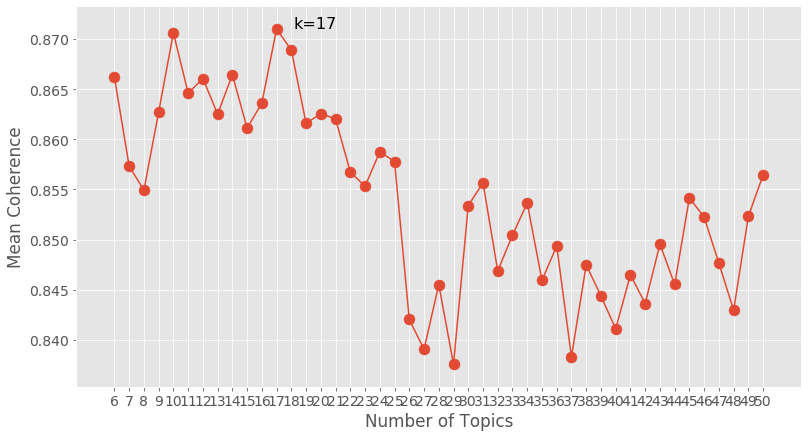

In [641]:
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

### Examine the Final  Model

The plot above suggests that the most appropriate value for the number of topics is *k=8*.

In [642]:
k = best_k
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

Display the topic descriptors for this model:

In [644]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10 )
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: light, shadow, photoluminescence, source, hits, lens, travels, penumbra, umbra, chemiluminescence
Topic 02: blood, heart, cells, body, oxygen, lungs, white, called, right, bone
Topic 03: water, filter, get, sugar, drink, humans, carbon, way, help, ground
Topic 04: red, green, blue, yellow, rose, eye, absorbed, cones, eyes, reflected
Topic 05: moss, grow, trees, plants, tree, spores, grows, live, plant, seeds
Topic 06: see, object, opaque, transparent, translucent, means, objects, glass, something, shadow
Topic 07: brain, body, part, parts, controls, stem, things, cerebrum, spinal, cord
Topic 08: food, system, eat, stomach, digestive, get, energy, intestine, small, nutrients
Topic 09: sun, moon, eclipse, earth, solar, shadow, lunar, front, blocks, learned
Topic 10: ants, ant, hills, queen, information, build, live, dirt, right, eat
Topic 11: mirror, concave, convex, reflection, lens, angle, mirrors, law, goes, flat
Topic 12: link, google, docs, edit, image, photosynthesis, sou